## Data preparation

The aim of this notebook is to prepare data for the training process. Generated floorplans
were pretty dirty so I cropped the area of the interest. Preparation pipeline:

1. Find biggest contour on the image
2. Resize samples according to the size of the flat (1kk must be smaller than 5kk) and get `target` image
3. Find entrance position (room colored in gray is forecourt) and draw it as red line.
4. Fill the contour with black color and get `input` image

In [1]:
import cv2
import numpy as np
from pathlib import Path
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

DELTA = 3000

In [2]:
# # read the data
# data_path = Path('./data/raw')
# data = defaultdict(list)
# for p in data_path.glob('**/*.png'):
#     parent = str(p.parent)
#     flat_type = parent.split('/')[-1]  # ex: 2kk, 2+1, 3kk, etc.
#     image = cv2.imread(p.as_posix())
#     data[flat_type].append(image)

In [3]:
data_path = './data/raw'
flat_folders = [f for f in os.listdir(data_path) if not f.startswith('.')]
flat_folders_sorted = sorted(flat_folders)

In [4]:
# define how much area will sample occupy in order to keep ratios of bigger flats
ratios = {}
# for f in flat_folders_sorted:
#     n_rooms = int(f[0])
#     if n_rooms in ratios.keys():
#         continue
#     ratio = .2 + np.log10(n_rooms)
#     ratios[n_rooms] = ratio

In [5]:
ratios = {
    1: 0.1,
    2: 0.25,
    3: 0.5,
    4: 0.75,
    5: 0.9
}

In [24]:
# helper functions
def get_biggest_contour(contours: list, img: np.array):
    """Returns biggest contour in the image as well as its drawn representation."""
    x, y = img.shape[0], img.shape[1]
    areas_cont = []
    for c in contours:
        c_area = cv2.contourArea(c)
        if np.abs(c_area - x * y) < DELTA:  # check if the contour is not image box
            continue
        areas_cont.append((c_area, c))
    sorted_areas = sorted(areas_cont, key=lambda x: x[0], reverse=True)
    biggest_contour = sorted_areas[0][1]

    zeros = np.zeros_like(img)
    return biggest_contour, cv2.drawContours(zeros, [biggest_contour], -1, (255,0,0), 3)

def get_contours(color_img: np.array):
    """Returns all contours in the picture."""
    gray = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
    kernel = np.ones(9).reshape(3,3)
    gray_erode = cv2.erode(gray, kernel).astype('uint8')
    thresh, mask = cv2.threshold(gray_erode, 0, 1, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def compute_image_size(bbox: tuple, n_rooms: int):
    """Compute the size of the new image according to ratio from bounding box.
    Not used after all.
    """
    ratio = ratios[n_rooms]
    _, _, w, h = bbox
    S = np.sqrt(w * h / ratio)
    if S < w or S < h:
        k = max(w, h) / S + .2
        S *= k
    return int(S)

def compute_image_size_contour(contour, bbox, n_rooms):
    """Compute the size of the new image according to ratio from contour."""
    ratio = ratios[n_rooms]
    _, _, w, h = bbox
    area = cv2.contourArea(contour)
    S_img = area / ratio
    side = np.sqrt(S_img) + 100 * 1 / n_rooms ** 2
    if side < w or side < h:
        k = max(w, h) / side + .2
        side *= k
    return int(side)

def smart_crop(img, flat_type):
    """Crops the image in accordance to flat's real size."""
    contours = get_contours(img)
    n_rooms = int(flat_type[0])
    biggest_contour, _ = get_biggest_contour(contours, img)
    bbox = cv2.boundingRect(biggest_contour)
    new_side = compute_image_size_contour(biggest_contour, bbox, n_rooms)
    empty = np.full((new_side, new_side, 3), 255)
    cropped = put_contour_contents_to_img(img, bbox, empty).astype('float32')
    return cropped

def put_contour_contents_to_img(source, bbox, dest):
    x, y, w, h = bbox
    new_h, new_w = dest.shape[:2]

    init_y = int((new_h - h ) / 2)
    init_x = int((new_w - w ) / 2)
    # print(f"""
    # Indexing x from {x} to {x+w}
    # Indexing y from {y} to {y+h}
    # New x {init_x} to {init_x+w}
    # New y {init_y} to {init_y+h}
    # Shape source  {source.shape}
    # Shape dest {dest.shape}
    # """)
    dest[init_y:init_y+h, init_x:init_x+w] = source[y:y+h, x:x+w]
    return dest

def fill_contour_black(img, contour):
    res = cv2.fillPoly(img, [contour], (0,0,0))
    return res

def draw_entrance_position(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    background = extract_background(gray)
    hall = extract_hall(gray)
    intersection = get_hall_background_intersection(background, hall)
    img_cpy = img.copy()
    img_cpy[intersection] = (0, 0, 255)  #draw entrance
    return img_cpy


def extract_hall(gray, dilate=True):
    thresh, mask1 = cv2.threshold(gray, 204, 1, cv2.THRESH_BINARY)
    thresh, mask2 = cv2.threshold(gray, 206, 1, cv2.THRESH_BINARY_INV)
    res = cv2.bitwise_and(mask1, mask2)
    if dilate:  # increase the hall mask so the intersection with background mask gives entrance mask
        kernel = np.ones(9).reshape(3,3)
        dilated = cv2.dilate(res, kernel, iterations=10)
        return dilated
    return res

def extract_background(gray):
    thresh, mask = cv2.threshold(gray, 250, 1, cv2.THRESH_BINARY)
    bin_mask = mask
    return bin_mask

def get_hall_background_intersection(background, hall):
    intersection = cv2.bitwise_and(background, hall)
    return intersection.astype('bool')

def resize_img(img, res=(300, 300)):
    return cv2.resize(img, res)

def save_image(img, path):
    dir_root = os.path.dirname(path)
    if not os.path.exists(dir_root):
        os.makedirs(dir_root)
    status = cv2.imwrite(path, img)

In [25]:
def process_sample(img, flat_type, plot=False):
    """Performs preprocessing pipeline."""
    target = smart_crop(img, flat_type)  # get target image

    X = target.copy()
    contours = get_contours(X)
    biggest_contour, biggest_contour_drawn = get_biggest_contour(contours, X)
    X = draw_entrance_position(X)
    X = fill_contour_black(X, biggest_contour)
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.imshow(X)
        ax1.set_title('X')
        ax2.imshow(target)
        ax2.set_title('target')
        plt.show()
    return X, target



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


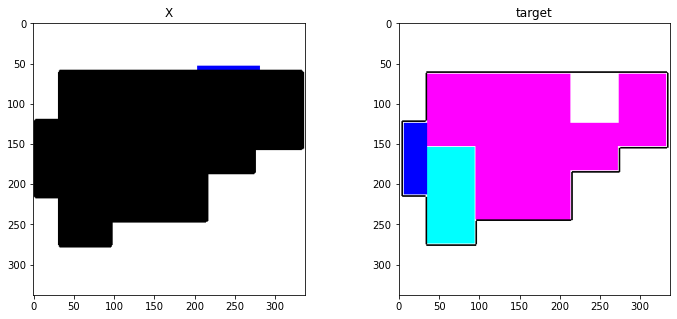

In [27]:
sample = cv2.imread('data/raw/3/Frame_00005.png')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
X, target = process_sample(sample, '3', plot=True)

In [28]:
data_path = './data'


for folder in flat_folders_sorted:
    print(f'Processing {folder}')
    target_path = data_path + '/raw/' + folder
    frames = sorted(os.listdir(target_path))
    for frame in tqdm(frames):
        if frame == '.DS_Store':
            continue
        img = cv2.imread(target_path + f'/{frame}')
        X, target = process_sample(img, folder)
        save_image(target, data_path + f'/output/{folder}_{frame}')
        save_image(X, data_path + f'/input/{folder}_{frame}')

Processing 1+1


100%|██████████| 151/151 [00:04<00:00, 35.11it/s]


Processing 1kk


100%|██████████| 201/201 [00:05<00:00, 35.99it/s]


Processing 2+1


100%|██████████| 152/152 [00:03<00:00, 50.08it/s]


Processing 2kk_entrance_forecourt


100%|██████████| 101/101 [00:01<00:00, 56.56it/s]


Processing 2kk_entrance_living_room


100%|██████████| 101/101 [00:02<00:00, 49.72it/s]


Processing 3


100%|██████████| 101/101 [00:01<00:00, 59.75it/s]


Processing 3+1


100%|██████████| 151/151 [00:02<00:00, 62.68it/s]


Processing 3kk_entrance_forecourt


100%|██████████| 201/201 [00:03<00:00, 56.53it/s]


Processing 3kk_luxe


100%|██████████| 201/201 [00:04<00:00, 44.95it/s]


Processing 4kk


100%|██████████| 201/201 [00:05<00:00, 33.74it/s]


Processing 5+1


100%|██████████| 201/201 [00:05<00:00, 35.17it/s]


Processing 5kk


100%|██████████| 201/201 [00:06<00:00, 31.58it/s]


Processing 5kk+balcony


100%|██████████| 201/201 [00:05<00:00, 34.20it/s]


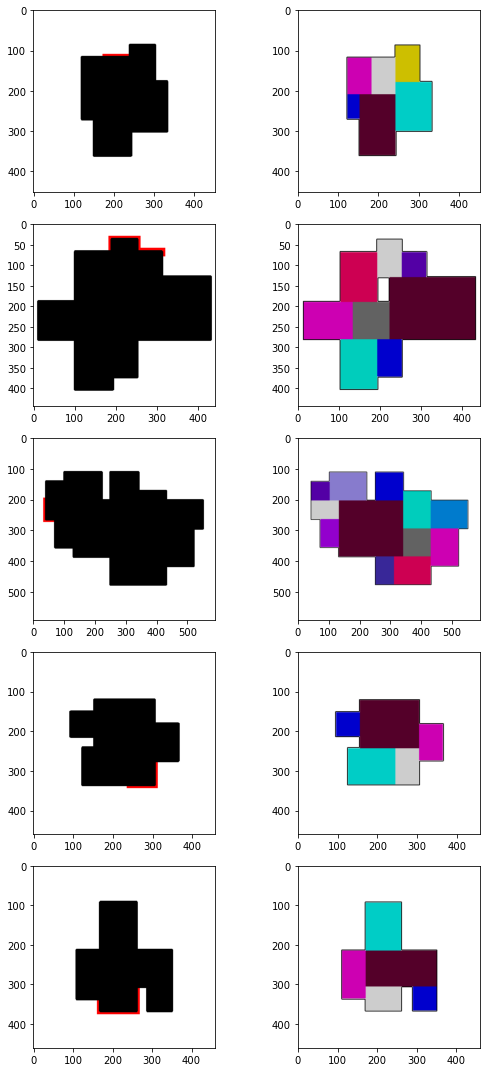

In [42]:
import random
n_samples = 5
random_samples = random.choices(os.listdir('./data/input/'), k=n_samples)
fig, axs = plt.subplots(n_samples, 2, figsize=(8, 3 * n_samples))
for i, s in enumerate(random_samples):
    X = cv2.imread(f'./data/input/{s}')
    y = cv2.imread(f'./data/output/{s}')
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
    axs[i][0].imshow(X)
    axs[i][1].imshow(y)
# plt.axes('off')
plt.tight_layout()
plt.show()